In [5]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU

import warnings
warnings.filterwarnings("ignore", category=UserWarning) # cuz my version of python complains about deprecated stuff

In [6]:
X = np.load('x_letters.npy')
y = np.load('y_letters.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X.shape, y.shape

((88799, 28, 28), (88799,))

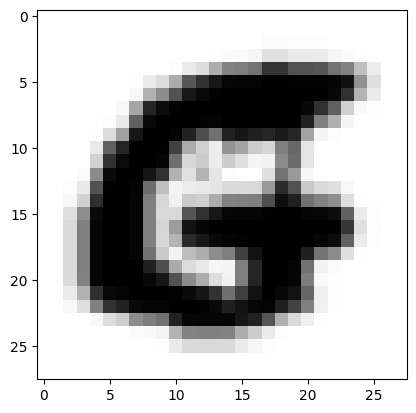

In [7]:
plt.imshow(X[0], cmap = 'binary')

### Regular GAN

In [8]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
       # sample random points
       batch_size = ops.shape(real_images)[0]
       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim)
       )

       # create fake images out of random vectors
       generated_images = self.generator(random_latent_vectors)

       # combine with real
       combined_images = ops.concatenate([generated_images, real_images], axis = 0)

       labels = ops.concatenate(
           [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis = 0
       )

       # add noise so the generator has a chance
       labels += 0.05*tf.random.uniform(tf.shape(labels))

       # train discriminator
       with tf.GradientTape() as tape:
          predictions = self.discriminator(combined_images)
          d_loss = self.loss_fn(labels, predictions)
       grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
       self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

       # sample random points again
       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim)
       )

       # misleading labels saying "all real"
       misleading_labels = ops.zeros((batch_size, 1))

       # train generator (don't touch the weights of the discriminator)
       with tf.GradientTape() as tape:
          predictions = self.discriminator(self.generator(random_latent_vectors))
          g_loss = self.loss_fn(misleading_labels, predictions)
       grads = tape.gradient(g_loss, self.generator.trainable_weights)
       self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

       # update metrics
       self.d_loss_metric.update_state(d_loss)
       self.g_loss_metric.update_state(g_loss)
       return {
           "d_loss" : self.d_loss_metric.result(),
           "g_loss" : self.g_loss_metric.result(),
       }


In [9]:
latent_dim = 32

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(256, activation="leaky_relu", kernel_initializer="he_normal"),
        layers.Dense(512, activation="leaky_relu", kernel_initializer="he_normal"),
        layers.Dense(28*28, activation="sigmoid"),
        layers.Reshape((28, 28)),
    ],
    name= "generator",
)

discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28)),
        layers.Flatten(),
        layers.Dense(150, activation="leaky_relu", kernel_initializer="he_normal"),
        layers.Dense(100, activation="leaky_relu", kernel_initializer="he_normal"),
        layers.Dense(1, activation="sigmoid"),
    ],
    name= "discriminator",
)

epochs = 20

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(X_train, epochs=epochs)

Epoch 1/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - d_loss: 0.6964 - g_loss: 1.0629
Epoch 2/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.5572 - g_loss: 1.4374
Epoch 3/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - d_loss: 0.4882 - g_loss: 1.7953
Epoch 4/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - d_loss: 0.4552 - g_loss: 1.9795
Epoch 5/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - d_loss: 0.4741 - g_loss: 1.8151
Epoch 6/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - d_loss: 0.3402 - g_loss: 2.3475
Epoch 7/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - d_loss: 0.2689 - g_loss: 2.9498
Epoch 8/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - d_loss: 0.2424 - g_loss: 3.4057
Epoch 9/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - d_loss: 0.2124 - g_loss: 3.7398
Epoch 10/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.2377 - g_loss: 3.9299
Epoch 11/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - d_loss: 0.2916 - g_loss: 3.4649
Epoch 12/20
2220/2220 ━━━━━━━━

In [10]:
def plot_string(n_images, generator, latent_dim):
    random_latent_vectors = keras.random.normal(shape=(n_images, latent_dim))

    images = generator(random_latent_vectors)

    plt.figure(figsize=(n_images * 1.5, 4))
    for image_index in range(n_images):
        plt.subplot(1, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
    plt.show()

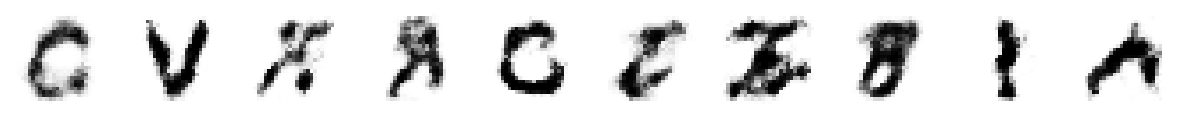

In [21]:
plot_string(10, generator, latent_dim)

### Changing to Conditional GAN

In [118]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data): # <-- instead of random points, you now package labels in too
       real_images, real_labels = data
       
       batch_size = ops.shape(real_images)[0]
       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim)
       )

       generated_images = self.generator([random_latent_vectors, real_labels]) # <-- same thing

       combined_images = ops.concatenate([generated_images, real_images], axis = 0)
       combined_labels = ops.concatenate([real_labels, real_labels], axis = 0) # <--

       labels = ops.concatenate(
           [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis = 0
       )

       labels += 0.05*tf.random.uniform(tf.shape(labels))

       with tf.GradientTape() as tape:
          predictions = self.discriminator([combined_images, combined_labels]) # <--
          d_loss = self.loss_fn(labels, predictions)
       grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
       self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

       random_latent_vectors = keras.random.normal(
           shape = (batch_size, self.latent_dim)
       )

       misleading_labels = ops.zeros((batch_size, 1))

       with tf.GradientTape() as tape:
          generated_images = self.generator([random_latent_vectors, real_labels]) # <--
          predictions = self.discriminator([generated_images, real_labels]) # <--
          g_loss = self.loss_fn(misleading_labels, predictions)
       grads = tape.gradient(g_loss, self.generator.trainable_weights)
       self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

       self.d_loss_metric.update_state(d_loss)
       self.g_loss_metric.update_state(g_loss)
       return {
           "d_loss" : self.d_loss_metric.result(),
           "g_loss" : self.g_loss_metric.result(),
       }

In [ ]:
num_classes = 26
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
label_input = keras.Input(shape=(num_classes,)) # makes it a tuple
noise_input = keras.Input(shape=(latent_dim,))
image_input = keras.Input(shape=(28, 28))

latent_dim = 32

# it's not sequential with image and label inputs, so now the structure has to change for both models

g = layers.Concatenate()([noise_input, label_input])
g = layers.Dense(256, activation="leaky_relu", kernel_initializer="he_normal")(g)
g = layers.Dense(784, activation="leaky_relu", kernel_initializer="he_normal")(g)
g = layers.Dense(28*28, activation="sigmoid")(g)
output = layers.Reshape((28, 28))(g)
generator = keras.Model([noise_input, label_input], output, name="generator")

d = layers.Flatten()(image_input)
d = layers.Concatenate()([d, label_input])
d = layers.Dense(150, activation="leaky_relu", kernel_initializer="he_normal")(d)
d = layers.Dense(100, activation="leaky_relu", kernel_initializer="he_normal")(d)
output = layers.Dense(1, activation="sigmoid")(d)
discriminator = keras.Model([image_input, label_input], output, name="discriminator")

epochs = 40

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# keras looks at top-level inputs, not for gen/disc, so you have to pack it as one input and then unpack it later in the train step
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat)).batch(64) 
gan.fit(train_dataset, epochs = epochs)

Epoch 1/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - d_loss: 0.6905 - g_loss: 1.1603
Epoch 2/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.4673 - g_loss: 1.6701
Epoch 3/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.5444 - g_loss: 1.5740
Epoch 4/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6409 - g_loss: 1.1879
Epoch 5/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6459 - g_loss: 1.0251
Epoch 6/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6517 - g_loss: 0.9516
Epoch 7/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6444 - g_loss: 0.9396
Epoch 8/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6423 - g_loss: 0.9409
Epoch 9/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6298 - g_loss: 0.9722
Epoch 10/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.6087 - g_loss: 1.0370
Epoch 11/40
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - d_loss: 0.5736 - g_loss: 1.1558
Epoch 12/40
1110/1110 ━━━━━━━━

Trial 1 (class code with 10 epochs) - generator loss explodes after 5+ epochs, discriminator loss decreases sharply

Trial 2 (increase generator neuron capacity to capture more complex patterns) - generator loss increases after 5ish epochs, but discriminator loss stabilizes at ~0.6

Trial 3 (decrease learning rate for generator to 0.0005 and generator to 0.001) - discriminator loss decreases, generator loss slowly increases

Trial 4 (swap generator to tanh over relu) - discriminator loss stabilizes to 0.53, generator loss decreases for a while to around 1.3 but then starts icnreasing

Trial 5 (swap discriminator to leaky_relu over relu, bump up epochs to 30) - discriminator loss stabilizes to 0.6ish, generator loss decreases and cuts off at 1.006

Trial 6 (bump up epochs to 40) - discriminator loss ends at 0.63, generator loss decreases to 0.966

Trial 7 (bump up epochs to 60) - discriminator loss ends at 0.64, generator loss decreases to 0.919

Trial 8 (added batch normalization in generator) - same performance as trial 6

Trial 9 (remove batch norms, add third layer in generator w/ 784 neurons) - 0.68 and 0.80 halfway, but started changing to 0.66 and 0.86 by epoch 60

Trial 10 (cut down epochs, remove 3rd layer and increase neurons in other 2) - 0.66 and 0.86

Trial 11 (decrease neurons in 1st, keep 2nd the same) - 0.67, 0.85. but the letters are the clearest yet

Trial 12 (swap back to leaky_relu instead of tanh cuz you typically don't use that with he_normal) - 0.49 and 1.8, but the letters are VERY clean

In [ ]:
def plot_string(string, generator, latent_dim, num_classes):
    n = len(string)
    
    random_latent_vectors = keras.random.normal(shape=(n, latent_dim))

    # for emnist, it's a = 1 to z = 26, so convert chars to indices. this uses unicode
    label_indices = np.array([ord(c.lower()) - ord('a') for c in string])
    labels = tf.keras.utils.to_categorical(label_indices, num_classes=num_classes)

    # convert both to tensors
    random_latent_vectors = tf.convert_to_tensor(random_latent_vectors, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)

    images = generator([random_latent_vectors, labels])

    plt.figure(figsize=(n * 1.5, 4))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap="binary")
        plt.axis("off")
    plt.show()


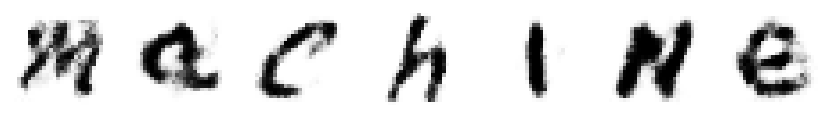

In [ ]:
plot_string("machine", generator, latent_dim, num_classes)

Class sampling w different latent vectors

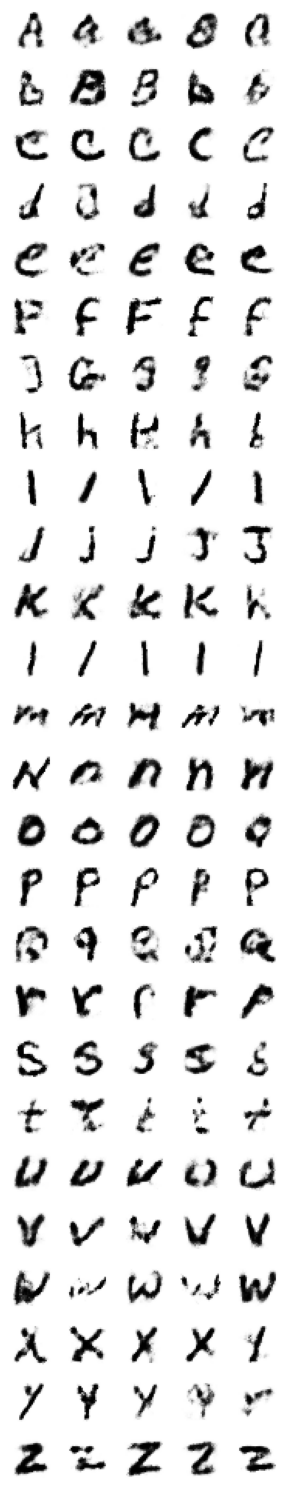

In [136]:
random_latent_vectors = keras.random.normal(shape=(26 * 5, latent_dim))

string = "abcdefghijklmnopqrstuvwxyz"

label_indices = np.array([ord(c.lower()) - ord('a') for c in string])
labels = np.repeat(label_indices, 5)
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

random_latent_vectors = tf.convert_to_tensor(random_latent_vectors, dtype=tf.float32)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

images = generator([random_latent_vectors, labels])

plt.figure(figsize=(2 * 1.5, 15))
for row, char in enumerate(string):
    for col in range(5):
        idx = row * 5 + col
        plt.subplot(26, 5, idx + 1)
        plt.imshow(images[idx], cmap="binary")
        plt.axis("off")
plt.tight_layout()
plt.show()

Interpolation between two latent vectors

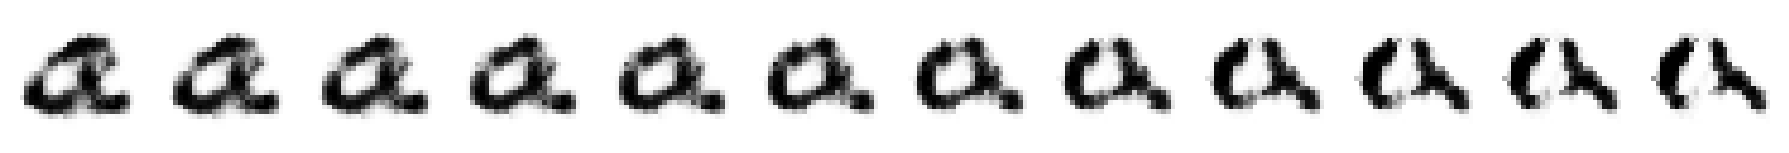

In [133]:
n_steps = 12

z0 = keras.random.normal(shape=(1, latent_dim))
z1 = keras.random.normal(shape=(1, latent_dim))

samples = tf.linspace(0.0, 1.0, n_steps)
Z = tf.concat([z0 * (1 - a) + z1 * a for a in samples], axis=0)

labels = tf.fill((n_steps,), 0)
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

imgs = generator([Z, labels])

plt.figure(figsize=(n_steps * 1.5, 2))
for i in range(n_steps):
    plt.subplot(1, n_steps, i + 1)
    plt.imshow(imgs[i], cmap='binary')
    plt.axis('off')
plt.tight_layout()
plt.show()
